### 분석 가정 : 변수에 대한 정보 X

## 모듈 불러오기

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 데이터 불러오기

In [9]:
planet = pd.read_csv("ML3rdweekdata.csv")
planet.head(3)

,Unnamed: 0,id,u,g,r,i,z,redshift,dered_u,dered_g,...,u_ratio,g_ratio,r_ratio,i_ratio,z_ratio,du_ratio,dg_ratio,dr_ratio,di_ratio,dz_ratio
0,46413,46412,20.569484,19.015036,18.216944,17.857745,17.878267,0.000218,18.95452,17.77918,...,0.219906,0.203288,0.194756,0.190915,0.191135,0.213666,0.200417,0.195709,0.194122,0.196086
1,303353,303352,19.219982,18.402198,18.254012,18.021883,17.915781,0.038436,19.12234,18.31982,...,0.209336,0.200429,0.198815,0.196287,0.195132,0.208945,0.200176,0.198849,0.196487,0.195543
2,37514,37513,25.896876,22.103648,20.490849,18.857178,17.931170,-0.000012,23.94866,21.10701,...,0.245982,0.209952,0.194632,0.179115,0.170319,0.237577,0.209387,0.196636,0.182215,0.174186


### 데이터 탐색

In [10]:
print(planet.shape)
print(planet.info())
print('\n결측값 수:',planet.isna().sum().sum())
planet['class'].value_counts()

(8000, 75)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        8000 non-null   int64  
 1   id                8000 non-null   int64  
 2   u                 8000 non-null   float64
 3   g                 8000 non-null   float64
 4   r                 8000 non-null   float64
 5   i                 8000 non-null   float64
 6   z                 8000 non-null   float64
 7   redshift          8000 non-null   float64
 8   dered_u           8000 non-null   float64
 9   dered_g           8000 non-null   float64
 10  dered_r           8000 non-null   float64
 11  dered_i           8000 non-null   float64
 12  dered_z           8000 non-null   float64
 13  nObserve          8000 non-null   int64  
 14  nDetect           8000 non-null   int64  
 15  airmass_u         8000 non-null   float64
 16  airmass_g         8000 non-null

2    3912
0    3039
1    1049
Name: class, dtype: int64

전부 연속형예측변수 / 반응변수 : class (0,1,2)

In [11]:
## index 컬럼 지워주기
planet.drop('Unnamed: 0',axis=1,inplace=True)
planet.head(3)

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,...,u_ratio,g_ratio,r_ratio,i_ratio,z_ratio,du_ratio,dg_ratio,dr_ratio,di_ratio,dz_ratio
0,46412,20.569484,19.015036,18.216944,17.857745,17.878267,0.000218,18.95452,17.77918,17.36149,...,0.219906,0.203288,0.194756,0.190915,0.191135,0.213666,0.200417,0.195709,0.194122,0.196086
1,303352,19.219982,18.402198,18.254012,18.021883,17.915781,0.038436,19.12234,18.31982,18.19839,...,0.209336,0.200429,0.198815,0.196287,0.195132,0.208945,0.200176,0.198849,0.196487,0.195543
2,37513,25.896876,22.103648,20.490849,18.857178,17.931170,-0.000012,23.94866,21.10701,19.82161,...,0.245982,0.209952,0.194632,0.179115,0.170319,0.237577,0.209387,0.196636,0.182215,0.174186


### 변수간 상관관계 파악

<AxesSubplot:>

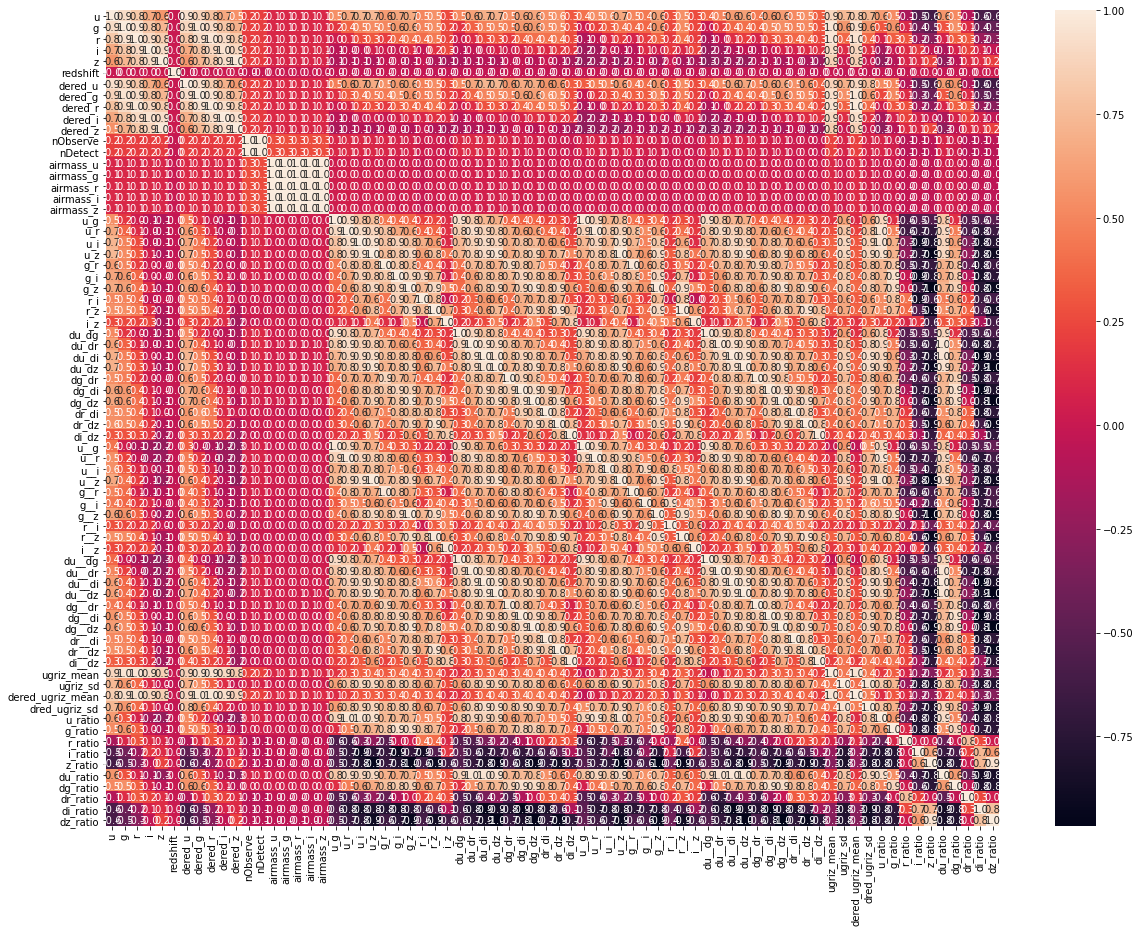

In [12]:
## id, class제외 모든 연속형 예측변수들 추출 후 상관계수 구하고 시각화
planet_for_corr = planet.drop(['id','class'],axis=1)
planet_corr = planet_for_corr.corr(method='pearson')

# 상관히트맵
plt.figure(figsize=(20,15))
sns.heatmap(planet_corr, annot=True, fmt='.1f') # 소수점 첫 째 자리까지

도저히 볼 수가 없고 변수 너무 많아 의미가 없다!!

In [13]:
# 상관관계 0.5이상, -0.5이하 인 것들 확인해보기
highcorr = (planet_corr<= -0.5) | (planet_corr>=0.5)
planet_corr[highcorr]
print('상관행렬 차원:',planet_corr.shape,'원소 개수:',72*72)
print('0.5이상 or -0.5이하 행렬 수:',highcorr.values.sum()) 

상관행렬 차원: (72, 72) 원소 개수: 5184
0.5이상 or -0.5이하 행렬 수: 2248


## PCA

In [14]:
# 개별 예측변수 스케일링(정규화)
planet_X = planet.drop(['id','class'],axis=1)
planet_scaled = StandardScaler().fit_transform(planet_X)
planet_pca_scaled = StandardScaler().fit_transform(planet_X)
# PCA 생성 , components = 30
pca = PCA(n_components=30)

# PCA 데이터 변환
pca.fit(planet_pca_scaled)
planet_pca = pca.transform(planet_pca_scaled)

# 분산비율 확인
print(pca.explained_variance_ratio_)

## 반응변수 따로 빼주기
planet_target = planet['class']

[4.86260814e-01 1.50663382e-01 9.73500602e-02 6.97896075e-02
 5.79607231e-02 4.02120304e-02 2.82234466e-02 2.33668381e-02
 1.56080358e-02 1.38654510e-02 5.23051337e-03 3.97716274e-03
 2.50162078e-03 2.25113911e-03 7.47717476e-04 4.76722237e-04
 3.60192960e-04 2.88894447e-04 1.83423307e-04 1.17579290e-04
 9.53078038e-05 9.16388394e-05 7.76002333e-05 6.70157864e-05
 5.40604973e-05 4.33216855e-05 3.45672579e-05 2.22788664e-05
 1.87415660e-05 1.33530928e-05]


<AxesSubplot:>

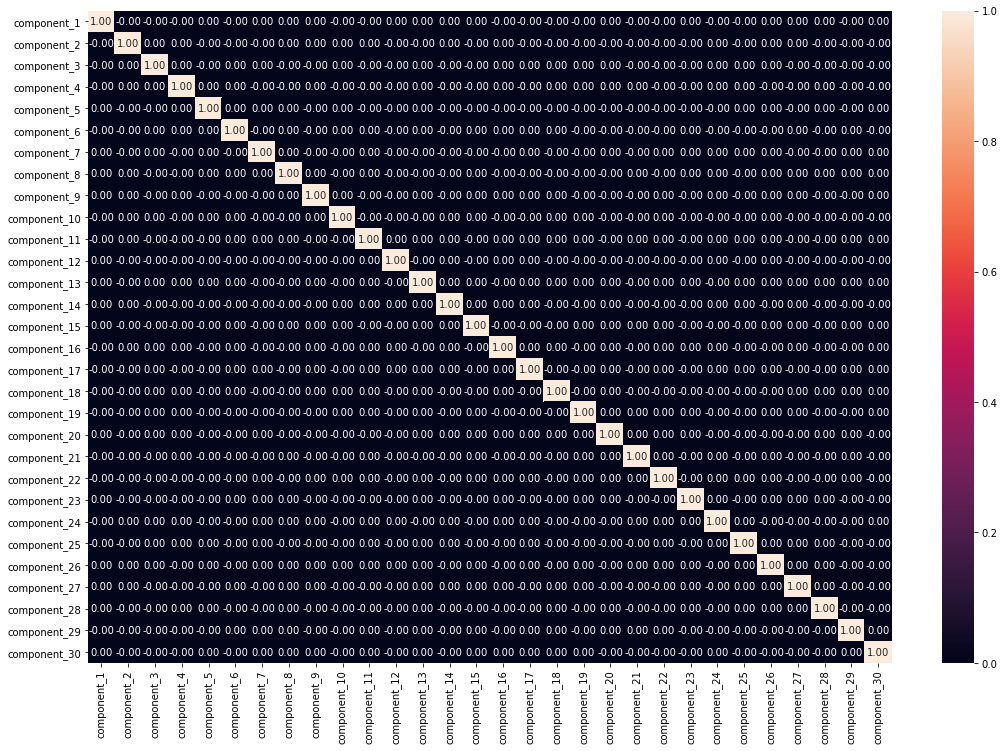

In [15]:
## PCA 변환 된 데이터 상관히트맵
# component1~30 만들기
components = ['component_'+ str(x) for x in list(range(1,31))]
# dataframe으로 변환
planetDF_pca = pd.DataFrame(data = planet_pca, columns = components)
planetDF_corr_pca = planetDF_pca.corr(method='pearson')
planetDF_corr_pca
# 상관히트맵
plt.figure(figsize=(18,12))
sns.heatmap(planetDF_corr_pca, annot=True, fmt='.2f') # 소수점 첫 째 자리까지b

In [28]:
planetDF_corr_pca

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30
component_1,1.000000e+00,-1.524392e-14,-1.640404e-16,-2.308564e-16,2.474956e-16,-2.696191e-16,6.292464e-16,3.012797e-16,1.807252e-16,-2.521384e-16,...,-1.051641e-15,-8.271995e-15,1.768700e-14,-7.803862e-15,-3.486755e-15,8.548401e-16,1.218640e-15,2.104814e-14,-8.396866e-16,3.769597e-14
component_2,-1.524392e-14,1.000000e+00,4.604879e-16,8.350379e-17,-5.142250e-16,-1.477357e-16,-1.807887e-16,1.737692e-16,4.419777e-16,2.597330e-17,...,-2.902701e-15,-1.850899e-15,-2.544955e-15,8.470553e-15,-1.183579e-14,1.049772e-15,3.971233e-15,-7.216734e-15,-5.637084e-15,-7.325578e-15
component_3,-1.640404e-16,4.604879e-16,1.000000e+00,1.013756e-16,-2.420250e-16,6.538607e-16,2.231872e-16,-1.917025e-16,-7.530751e-17,2.027457e-16,...,-6.558726e-16,-2.497496e-16,-5.189932e-15,5.072352e-15,1.665708e-15,1.501105e-14,-1.237043e-15,-1.209636e-14,-1.550798e-14,-1.624042e-14
component_4,-2.308564e-16,8.350379e-17,1.013756e-16,1.000000e+00,3.904028e-16,1.167963e-15,-3.404610e-16,-1.592276e-17,2.092140e-16,-2.716104e-17,...,1.262494e-15,-3.366844e-15,-3.338361e-15,1.728836e-15,9.059259e-16,-5.225326e-14,-1.309483e-15,2.877844e-16,-7.167487e-15,-7.065809e-15
component_5,2.474956e-16,-5.142250e-16,-2.420250e-16,3.904028e-16,1.000000e+00,1.426840e-16,1.547425e-16,1.853867e-16,-3.043268e-17,1.050037e-17,...,-4.068042e-15,-8.357523e-15,-6.674231e-15,-3.495362e-15,4.474863e-15,4.053481e-15,-4.635772e-15,7.992694e-16,-3.986453e-15,8.712793e-15
component_6,-2.696191e-16,-1.477357e-16,6.538607e-16,1.167963e-15,1.426840e-16,1.000000e+00,-6.102017e-16,1.610755e-16,-5.136312e-16,6.136484e-16,...,-3.719943e-15,-1.796723e-15,1.055593e-15,-4.001650e-15,-4.881819e-15,-1.301049e-15,1.738984e-15,-1.029878e-14,9.774368e-15,-1.546731e-14
component_7,6.292464e-16,-1.807887e-16,2.231872e-16,-3.404610e-16,1.547425e-16,-6.102017e-16,1.000000e+00,2.621545e-15,-3.874401e-16,-4.990787e-16,...,-4.914507e-15,9.704153e-16,5.105638e-16,7.764433e-16,9.052948e-15,2.616301e-15,-6.381170e-16,-4.385380e-15,6.150975e-16,9.348872e-15
component_8,3.012797e-16,1.737692e-16,-1.917025e-16,-1.592276e-17,1.853867e-16,1.610755e-16,2.621545e-15,1.000000e+00,8.497659e-16,-2.648325e-16,...,2.060522e-14,-2.903685e-15,6.217679e-15,9.091955e-15,-7.669593e-16,4.566151e-16,1.142606e-15,1.372159e-15,3.027084e-15,8.848300e-16
component_9,1.807252e-16,4.419777e-16,-7.530751e-17,2.092140e-16,-3.043268e-17,-5.136312e-16,-3.874401e-16,8.497659e-16,1.000000e+00,1.166286e-16,...,-1.464657e-15,1.107301e-15,-4.374298e-16,4.218552e-15,-4.567236e-15,3.026969e-15,1.679938e-15,-2.728369e-16,-2.653560e-15,1.648930e-15
component_10,-2.521384e-16,2.597330e-17,2.027457e-16,-2.716104e-17,1.050037e-17,6.136484e-16,-4.990787e-16,-2.648325e-16,1.166286e-16,1.000000e+00,...,-3.649653e-15,7.624063e-16,-7.800172e-17,-6.272697e-16,-2.434533e-15,4.870412e-16,-1.923480e-15,-5.731324e-15,-7.175931e-16,-1.512793e-15


PCA 변환된 데이터 상관계수 전부 0에 가까움.

In [16]:
## component별 분산비율 DataFrame 만들어 확인해보기
# component1~30 만들기
components = ['component_'+ str(x) for x in list(range(1,31))]

# Propertion of Variance(분산비율)
PoV = pca.explained_variance_ratio_

# Cumulative Proportion(분산의 누적 합계)
CP = []
a = 0
for i in range(0,30):
   a += pca.explained_variance_ratio_[i]
   CP.append(a)
    
# DataFrame 만들기
dict = {'PoV' : PoV, 'CP' : CP}
components_df = pd.DataFrame(data = dict, index = components)
components_df

,PoV,CP
component_1,0.486261,0.486261
component_2,0.150663,0.636924
component_3,0.097350,0.734274
component_4,0.069790,0.804064
component_5,0.057961,0.862025
component_6,0.040212,0.902237
component_7,0.028223,0.930460
component_8,0.023367,0.953827
component_9,0.015608,0.969435
component_10,0.013865,0.983300


4개의 성분으로 데이터의 변동성 약 80% 설명 가능.  
6개의 성분으로 데이터의 변동성 약 90% 설명 가능.  
8개의 성분으로 데이터의 변동성 약 95% 설명 가능.

In [17]:
## PCA 변환 데이터프레임 만들기
planetDF_pca = pd.DataFrame(planet_pca, columns=components)
planetDF_pca['target'] = planet_target
planetDF_pca.head(3)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,target
0,2.342048,-0.261471,0.918289,3.825032,-0.555898,0.045111,-0.156728,-0.086478,-1.898497,-0.253871,...,-0.062775,-0.030370,-0.023864,-0.007492,0.029046,0.071427,-0.000383,-0.024818,0.016140,0
1,5.435990,2.564828,-0.526863,1.052028,-0.461979,0.154638,-0.500850,-0.290766,0.067841,-0.071852,...,0.022645,-0.007664,0.039809,0.031060,-0.047725,-0.017685,0.004436,0.007835,-0.003139,1
2,-15.961433,1.583198,1.503253,-0.915404,-1.979179,1.624319,-1.345930,-0.931494,-1.907606,-0.161921,...,-0.096912,0.025939,0.070036,-0.005998,-0.092655,0.034875,-0.070650,-0.038261,-0.011876,0


## LDA

In [18]:
## LDA 만들기 / components=30
lda = LinearDiscriminantAnalysis(n_components=2)  # target값 클래스 3개이므로 n_components 최대 2개
lda.fit(planet_scaled, planet_target) # 지도학습이므로 target값 필요
planet_lda = lda.transform(planet_scaled)
print(planet_lda.shape)

(8000, 2)


<AxesSubplot:xlabel='lda_component_1', ylabel='lda_component_2'>

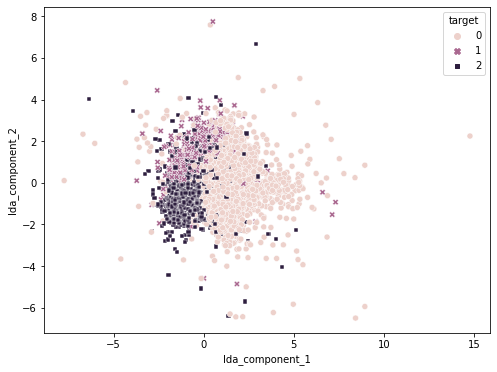

In [19]:
## 시각화
planet_columns=['lda_component_1','lda_component_2']
planetDF_lda = pd.DataFrame(planet_lda, columns=planet_columns)
planetDF_lda['target']=planet_target

plt.figure(figsize=(8,6))
sns.scatterplot(data=planetDF_lda, x='lda_component_1', y='lda_component_2', hue='target', style='target')

# PCA 변환 데이터 & LDA 변환 데이터 예측성능평가

In [20]:
# 분류기 생성 / RandomForestClassifier
rcf = RandomForestClassifier(random_state=27)

# 원본데이터 랜덤포레스트 적용
scores = cross_val_score(rcf, planet_X, planet_target, scoring='accuracy',cv=5)

# PCA 변환 데이터 랜덤포레스트 적용
scores_pca = cross_val_score(rcf, planetDF_pca.iloc[:,:30], planet_target, scoring='accuracy', cv=5)

# LDA 변환 데이터 랜덤포레스트 적용
scores_lda = cross_val_score(rcf, planetDF_lda.iloc[:,:2], planet_target, scoring='accuracy', cv=5)

print('원본 데이터 교차 검증 개별 정확도:',scores)
print('원본 데이터 평균 정확도:',np.mean(scores))
print('\nPCA 변환 데이터 교차 검증 개별 정확도:',scores_pca)
print('PCA 변환 데이터 평균 정확도:',np.mean(scores_pca))
print('\nLDA 변환 데이터 교차 검증 개별 정확도:',scores_lda)
print('LDA 변환 데이터 평균 정확도:', np.mean(scores_lda))

원본 데이터 교차 검증 개별 정확도: [0.91625  0.916875 0.9125   0.9125   0.920625]
원본 데이터 평균 정확도: 0.9157500000000001

PCA 변환 데이터 교차 검증 개별 정확도: [0.908125 0.89375  0.9      0.896875 0.9     ]
PCA 변환 데이터 평균 정확도: 0.89975

LDA 변환 데이터 교차 검증 개별 정확도: [0.794375 0.786875 0.810625 0.8075   0.8     ]
LDA 변환 데이터 평균 정확도: 0.7998750000000001


In [21]:
## StratifiedKFold 통한 원본데이터, PCA 변환 데이터, LDA 변환 데이터 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)

scores = cross_val_score(rcf, planet_X, planet_target, scoring='accuracy',cv=skf)

# PCA 변환 데이터 랜덤포레스트 적용
scores_pca = cross_val_score(rcf, planetDF_pca.iloc[:,:30], planet_target, scoring='accuracy', cv=skf)

# LDA 변환 데이터 랜덤포레스트 적용
scores_lda = cross_val_score(rcf, planetDF_lda.iloc[:,:2], planet_target, scoring='accuracy', cv=skf)

print('원본 데이터 교차 검증 개별 정확도:',scores)
print('원본 데이터 평균 정확도:',np.mean(scores))
print('\nPCA 변환 데이터 교차 검증 개별 정확도:',scores_pca)
print('PCA 변환 데이터 평균 정확도:',np.mean(scores_pca))
print('\nLDA 변환 데이터 교차 검증 개별 정확도:',scores_lda)
print('LDA 변환 데이터 평균 정확도:', np.mean(scores_lda))

원본 데이터 교차 검증 개별 정확도: [0.910625 0.911875 0.92375  0.924375 0.9125  ]
원본 데이터 평균 정확도: 0.916625

PCA 변환 데이터 교차 검증 개별 정확도: [0.895    0.9      0.890625 0.908125 0.9025  ]
PCA 변환 데이터 평균 정확도: 0.89925

LDA 변환 데이터 교차 검증 개별 정확도: [0.804375 0.791875 0.7875   0.81     0.814375]
LDA 변환 데이터 평균 정확도: 0.8016249999999999


기본 cross_val_score(cv=5)와 cv에 StratifiedKFold로 만든 파라미터 설정한 것 차이 X    
  
일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다.  
또한, cross_val_score 함수에는 KFold의 매개변수를 제어할 수가 없으므로,   
따로 KFold 객체를 만들고 매개변수를 조정한 다음에 cross_val_score의 cv 매개변수에 넣어야 한다

## 로지스틱회귀모형 단계적 변수선택법 / 대체 어떻게 하는걸까?

In [22]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [23]:
x2 = sm.add_constant(planet_X)
model = sm.OLS(planet_target, x2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  class   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     148.2
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:50:42   Log-Likelihood:                -8178.3
No. Observations:                8000   AIC:                         1.645e+04
Df Residuals:                    7951   BIC:                         1.680e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               87.8849     10.603  

In [24]:
## model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial') 

## 랜덤포레스트 변수중요도

In [25]:
# 랜덤포레스트를 이용한 영향력 도출
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100).fit(planet_X, planet_target)
cross_val_score(rf, planet_X, planet_target, cv=3)

feature_importance_rf = pd.DataFrame(zip(planet_X.columns, rf.feature_importances_))
feature_importance_rf.columns = ['feature', 'importance']
feature_importance_rf.sort_values("importance", ascending=False, inplace=True)

In [26]:
feature_importance_rf.iloc[:20,:]

,feature,importance
5,redshift,0.234241
55,dr__di,0.044393
59,ugriz_sd,0.037051
56,dr__dz,0.032247
36,dr_dz,0.032032
35,dr_di,0.031306
69,dr_ratio,0.027464
20,u_i,0.026038
64,r_ratio,0.024050
61,dred_ugriz_sd,0.020940


In [27]:
## 랜덤포레스트 변수중요도 상위 20개 뽑아서 예측성능평가
top20 = feature_importance_rf.iloc[:20,:]['feature']
planet_rf_X = planet[top20]

rcf = RandomForestClassifier(random_state=27)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)

scores_rf = cross_val_score(rcf, planet_rf_X, planet_target, scoring='accuracy',cv=skf)

print('원본 데이터 교차 검증 개별 정확도:',scores_rf)
print('원본 데이터 평균 정확도:',np.mean(scores_rf))

원본 데이터 교차 검증 개별 정확도: [0.919375 0.9125   0.919375 0.925    0.9125  ]
원본 데이터 평균 정확도: 0.9177500000000001


## 참고사이트

데이터 프레임 만들기  
https://dsbook.tistory.com/12

랜덤포레스트 변수중요도
https://wikidocs.net/16882

회귀모형 변수선택
https://myjamong.tistory.com/80